In [ ]:
#|default_exp diffusion_trajectories
#| hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Diffusion Trajectory Distance Normalization
> Curvature curves, vs distance instead of time

Diffusion curvature would be more robust if we could compare diffusion laziness across multiple times. This we tried -- with 'curvature curves'. But while these curvature curves show robust differences when sampled in the same part of one manifold, they become fickle when comparing across manifolds. This was investigated in 3a-are-kernels-zeitgeibers, in which we concluded that the kernel bandwidth determines the *speed of time*, and thus makes curvature curves impossible to compare without some kernel bandwidth normalization.

Here we attempt such a normalization, except instead of trying to estimate and cancel out the effects of the kernel bandwidth, we plot the laziness not with respect to time, but rather the *diffusion distance* along the 'diffusion trajectory', formed by viewing each diffusion as a space in the diffusion coordinate system.

**Hypothesis**: Plotting wrt. diffusion distance will enable curvature curves from different manifolds to accurately reflect curvature differences.

## Summary

Normalizing by distance is a great boon.
In six consecutive trials, the distance-normalized curvature curves correctly ordered curvatures, despite the failure to do so by regular curvature curves.

# Machinery

First we'll adapt the curvature curve code from 3a to compute these distances along diffusion trajectories.

In [ ]:
#|export
from scipy.spatial.distance import jensenshannon
def diffusion_distances_along_trajectory(diffusions):
    # given a sequence of diffusions, returns the distances between each 
    distances = [0]
    for idx in range(len(diffusions)-1):
        distances.append(
            # distances[-1] + np.linalg.norm(
            #     diffusions[idx+1] - diffusions[idx]
            # )
            distances[-1] + jensenshannon(diffusions[idx+1], diffusions[idx])
            
        )
    return np.array(distances)

In [ ]:
diffusions = np.random.rand(51,100)
ds = diffusion_distances_along_trajectory(diffusions)
assert len(ds) == len(diffusions)

In [ ]:
#|export
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from fastcore.all import *
from diffusion_curvature.core import *
from tqdm.auto import tqdm
import inspect

@patch
def curvature_curve(self:DiffusionCurvature, 
                    num_ts=50, 
                    idx = 0, 
                    **kwargs
                    ):    
    curvatures = []
    Pts = []
    t_values = np.arange(1, num_ts+1)
    for t in tqdm(t_values):
        laziness, laziness_nought, P, Pt, t = self.unsigned_curvature(self.G, int(t), _also_return_first_scale=True, **kwargs)
        if len(Pts) == 0: Pts.append(np.eye(len(P))[idx])
        curvatures.append(laziness[idx])
        Pts.append(Pt[idx])
    # compute distances along trajectory
    # distances_along_trajectory = diffusion_distances_along_trajectory(Pts)
    distances_along_trajectory = diffusion_distances_along_trajectory(Pts)[1:]
    curvatures = np.array(curvatures)
    return t_values, distances_along_trajectory, curvatures

def show_curvature_curves(*diffusion_curvatures, num_ts=50, idx=0, scaling_fn=None, title="Curvature Curves", **kwargs):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for dc in diffusion_curvatures:
        dc_name = None
        for frame_record in inspect.stack():
            frame = frame_record.frame
            for name, obj in frame.f_globals.items():
                if obj is dc:
                    dc_name = name
            for name, obj in frame.f_locals.items():
                if obj is dc:
                    dc_name = name
        if dc_name is None:
            dc_name = "Unknown"
        
        t_values, distances, curvatures = dc.curvature_curve(num_ts=num_ts, idx=idx, **kwargs)
        axs[0].plot(distances, curvatures, label=dc_name)
        axs[1].plot(t_values, curvatures, label=dc_name)
        
    axs[0].set_title("Spread of diffusion vs distance along diffusion trajectory")
    axs[1].set_title("Spread of diffusion vs time")
    axs[1].set_xlabel('Time ($t$)')    
    axs[1].set_ylabel('Spread of diffusion')
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Spread of diffusion')
    fig.suptitle(title)
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [ ]:
def sample_ssp_dcs(n_points, dim, graph_former, laziness_method = "Entropic"):
    X_saddle, ks = rejection_sample_from_saddle(n_points, intrinsic_dim=dim)
    G_saddle = graph_former(X_saddle)
    DC_saddle = DiffusionCurvature(
        laziness_method=laziness_method,
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
        distance_t = 25,
        verbose=False,
        smoothing = None,
    )
    ks = DC_saddle.fit_transform(G_saddle, dim=dim, t=25)

    X_sphere, ks_sphere = sphere(n_points, d=dim)
    G_sphere = graph_former(X_sphere)
    DC_sphere = DiffusionCurvature(
        laziness_method=laziness_method,
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
        verbose=False,
        smoothing = None,
        distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
    )
    ks = DC_sphere.fit_transform(G_sphere, dim=dim, t=25)

    X_plane = plane(n_points, dim=dim)
    G_plane = graph_former(X_plane)
    DC_plane = DiffusionCurvature(
        laziness_method=laziness_method,
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
        verbose=False,
        smoothing = None,
        distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
    )
    ks = DC_plane.fit_transform(G_plane, dim=dim, t=25)
    return DC_saddle, DC_sphere, DC_plane

# Results

In [ ]:
from collections import defaultdict

# Function to create a new defaultdict of defaultdicts
def nested_dict():
    return defaultdict(nested_dict)
result_dict = nested_dict()

Notes:
- It matters a great deal where one begins the distance calculation. From a dirac? Or from the first scale of diffusion? Beginning from the dirac helps correct for differences that begin on the first scale.
- Having self loops in the graph adjacency matrix seems to help.
- Using the Jensen-Shannon Distance instead of the euclidean distance between diffusions helps a great deal.
- Not much difference between using and omitting anisotropic normalization, when using the JSD.

## Adaptive Kernel

## Without Anisotropy

2024-07-01 17:57:35,839:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:57:36,422:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:57:37,003:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:57:37,627:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:57:38,176:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:57:38,786:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

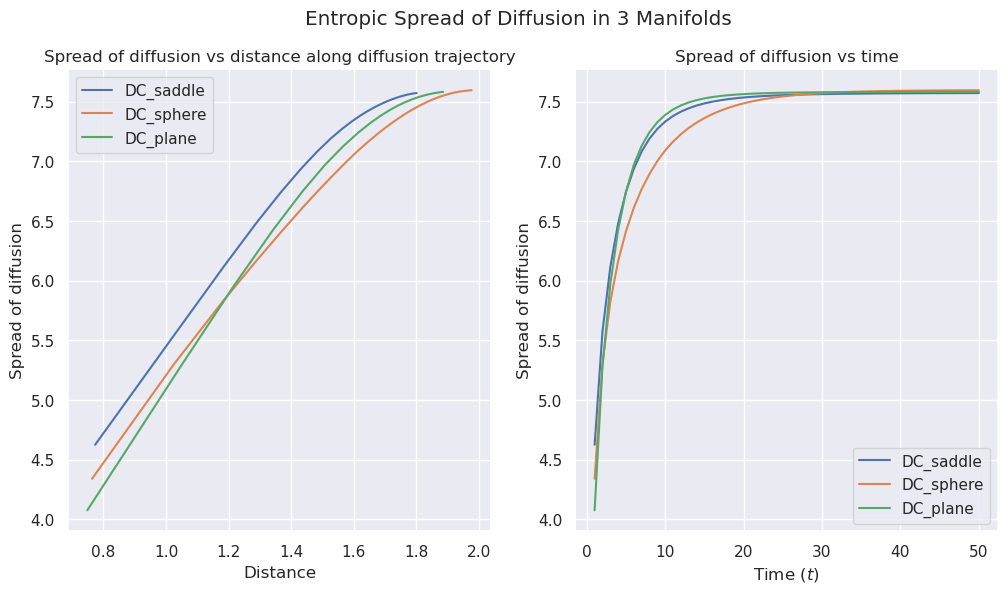

In [ ]:
graph_former = partial(get_adaptive_graph, alpha=0, k=5)

DC_saddle, DC_sphere, DC_plane = sample_ssp_dcs(
    n_points = 2000, dim = 3, graph_former = graph_former, laziness_method = 'Entropic'
)

show_curvature_curves(DC_saddle, DC_sphere, DC_plane, num_ts=50, title = "Entropic Spread of Diffusion in 3 Manifolds")

2024-07-01 17:59:02,762:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:03,386:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:04,063:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:04,719:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:05,325:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:05,966:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

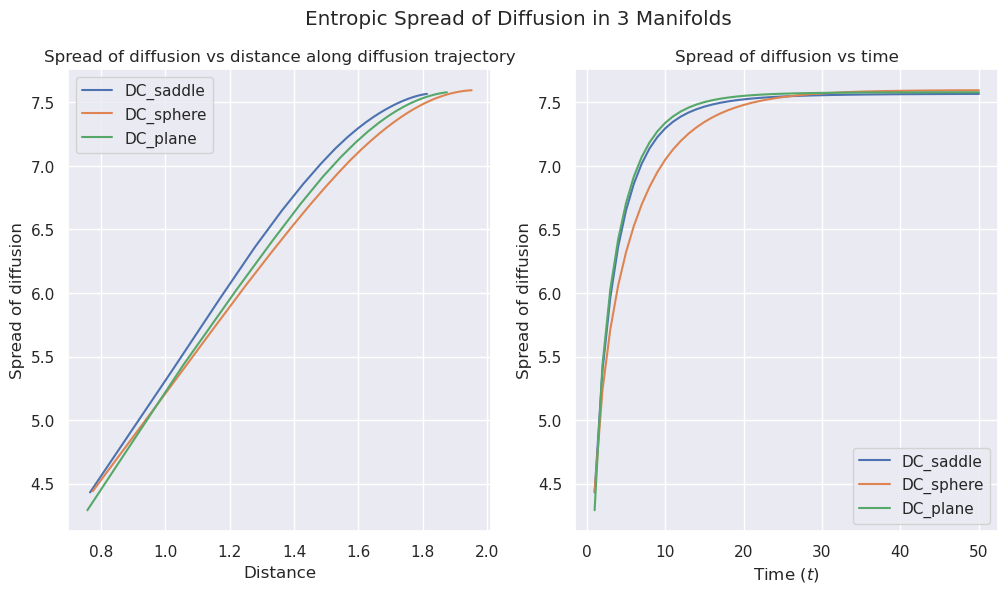

In [ ]:
graph_former = partial(get_adaptive_graph, alpha=0, k=5)

DC_saddle, DC_sphere, DC_plane = sample_ssp_dcs(
    n_points = 2000, dim = 3, graph_former = graph_former, laziness_method = 'Entropic'
)

show_curvature_curves(DC_saddle, DC_sphere, DC_plane, num_ts=50, title = "Entropic Spread of Diffusion in 3 Manifolds")

2024-07-01 17:59:31,774:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:32,451:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:33,431:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:34,071:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:34,654:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 17:59:35,219:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

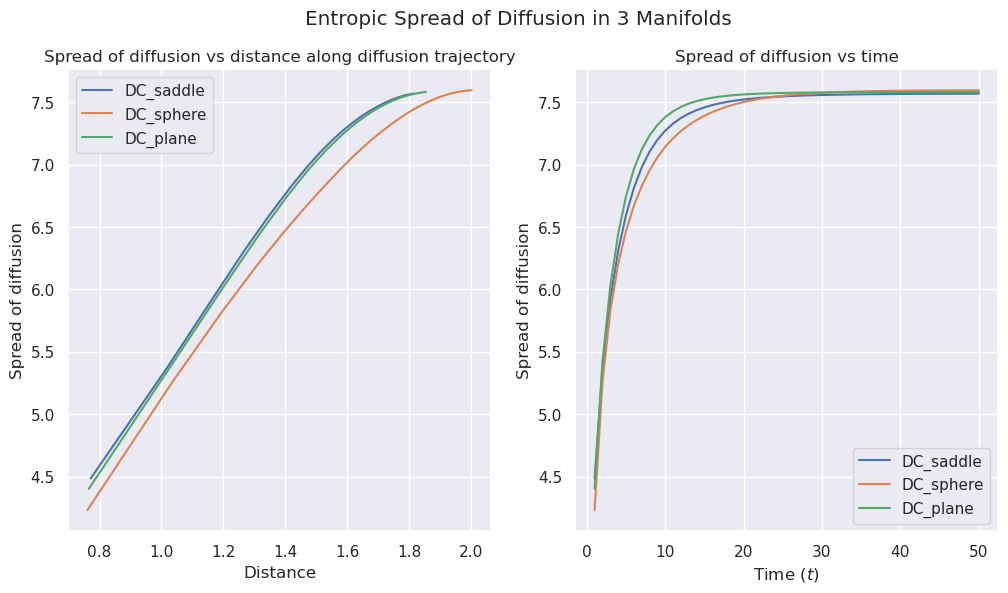

In [ ]:
graph_former = partial(get_adaptive_graph, alpha=0, k=5)

DC_saddle, DC_sphere, DC_plane = sample_ssp_dcs(
    n_points = 2000, dim = 3, graph_former = graph_former, laziness_method = 'Entropic'
)

show_curvature_curves(DC_saddle, DC_sphere, DC_plane, num_ts=50, title = "Entropic Spread of Diffusion in 3 Manifolds")

## With Anisotropy

2024-07-01 18:00:14,028:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:14,476:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:14,923:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:15,385:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:15,830:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:16,310:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

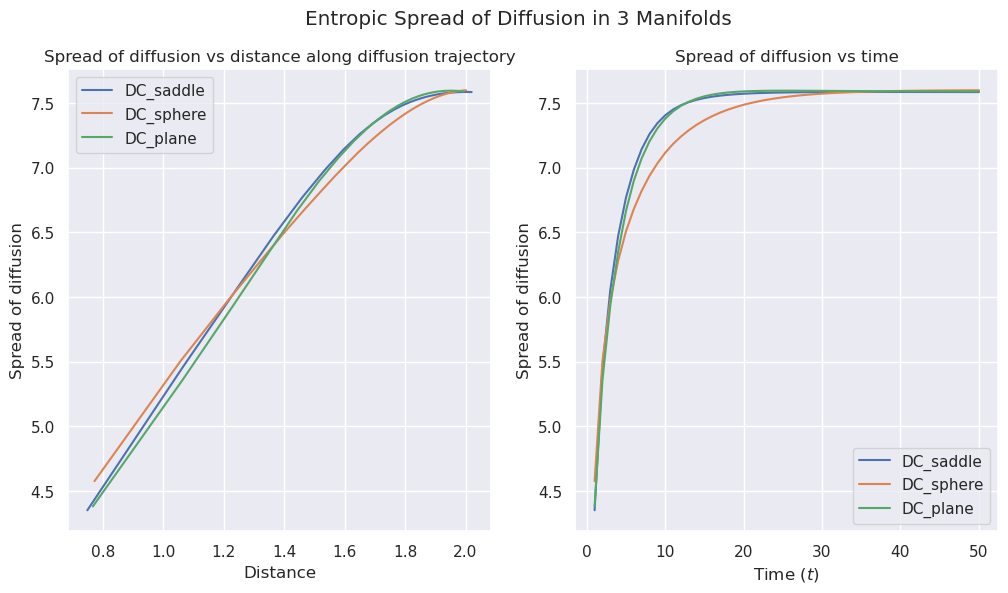

In [ ]:
graph_former = partial(get_adaptive_graph, alpha=1, k=5)

DC_saddle, DC_sphere, DC_plane = sample_ssp_dcs(
    n_points = 2000, dim = 3, graph_former = graph_former, laziness_method = 'Entropic'
)

show_curvature_curves(DC_saddle, DC_sphere, DC_plane, num_ts=50, title = "Entropic Spread of Diffusion in 3 Manifolds")

2024-07-01 18:00:38,395:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:38,879:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:39,405:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:39,923:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:40,409:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:00:40,962:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

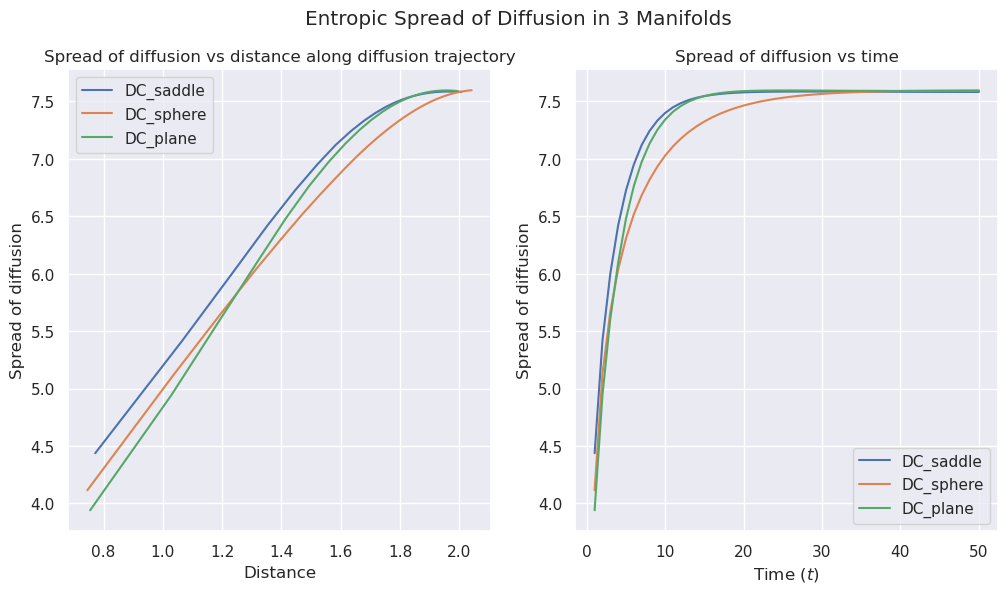

In [ ]:
graph_former = partial(get_adaptive_graph, alpha=1, k=5)

DC_saddle, DC_sphere, DC_plane = sample_ssp_dcs(
    n_points = 2000, dim = 3, graph_former = graph_former, laziness_method = 'Entropic'
)

show_curvature_curves(DC_saddle, DC_sphere, DC_plane, num_ts=50, title = "Entropic Spread of Diffusion in 3 Manifolds")

2024-07-01 18:01:05,949:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:01:06,443:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:01:06,863:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:01:07,377:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:01:07,810:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-07-01 18:01:08,261:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

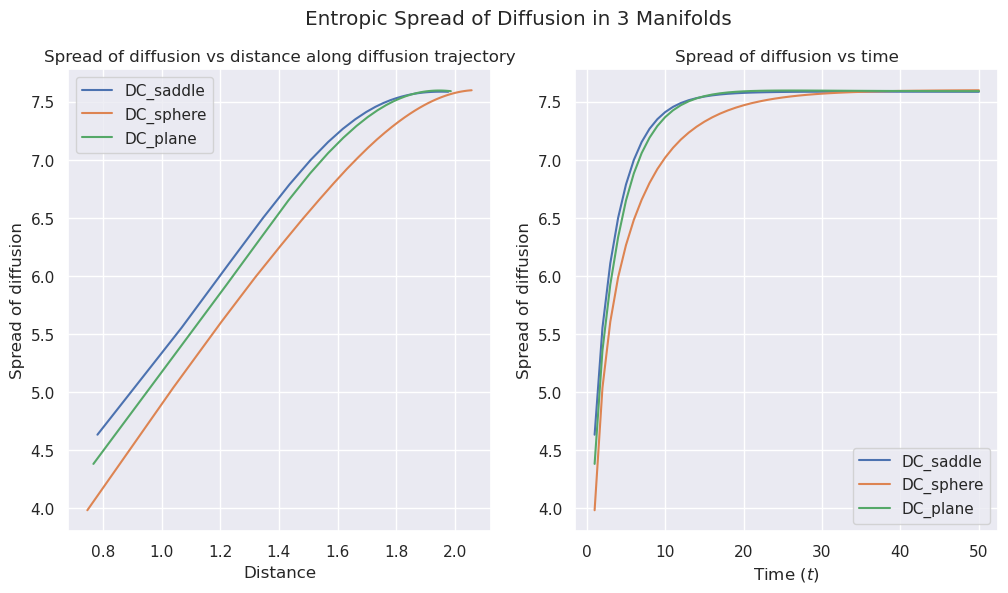

In [ ]:
graph_former = partial(get_adaptive_graph, alpha=1, k=5)

DC_saddle, DC_sphere, DC_plane = sample_ssp_dcs(
    n_points = 2000, dim = 3, graph_former = graph_former, laziness_method = 'Entropic'
)

show_curvature_curves(DC_saddle, DC_sphere, DC_plane, num_ts=50, title = "Entropic Spread of Diffusion in 3 Manifolds")

## With Fixed Graph

In [ ]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=3)
graph_former = partial(get_fixed_graph, sigma=0.2, alpha=0)
G_saddle = graph_former(X_saddle)
DC_saddle = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    distance_t = 25,
    verbose=False,
)
ks = DC_saddle.fit_transform(G_saddle, dim=2, t=25)

In [ ]:
X_sphere, ks_sphere = sphere(2000, d=3)
G_sphere = graph_former(X_sphere)
DC_sphere = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere.fit_transform(G_sphere, dim=2, t=25)

In [ ]:
X_plane = plane(2000, dim=3)
G_plane = graph_former(X_plane)
DC_plane = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane.fit_transform(G_plane, dim=2, t=25)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

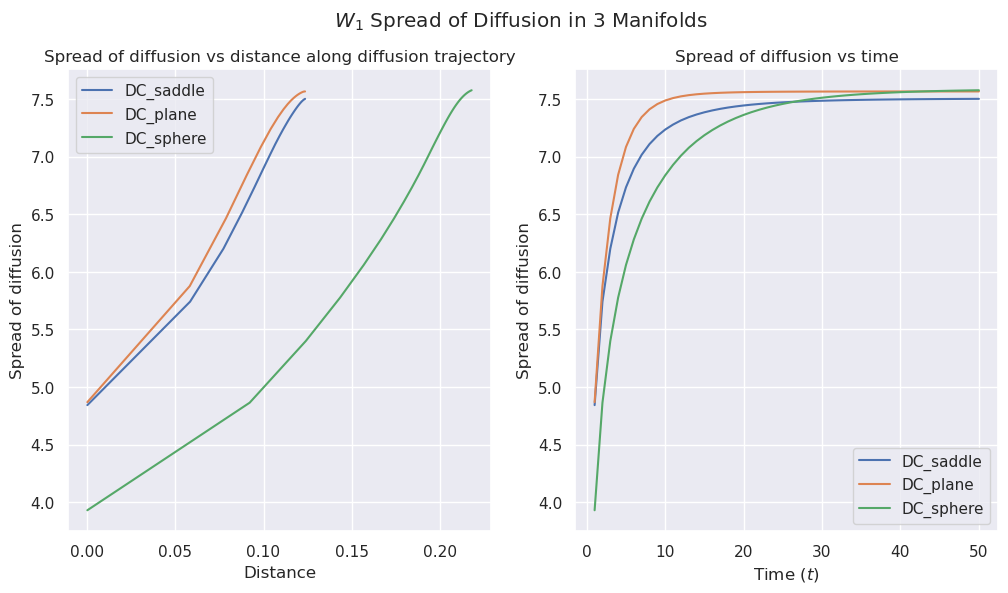

In [ ]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, num_ts=50, title = " $W_1$ Spread of Diffusion in 3 Manifolds")

# Conclusion